In [1]:
import torch
import numpy as np
import sys
import os

sys.path.append(os.getcwd()+'/src/')
%load_ext autoreload
%autoreload 2

from attribute import *
from plot import *
from ppo_policy import *
from utils import *

/Users/amalota/anaconda3/envs/py37_trainloop/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sb3_contrib import RecurrentPPO

In [3]:
model = RecurrentPPO.load('../best_model/recurrentppo/MlpLstmPolicy/best_model.zip')
# model = RecurrentPPO.load('../output_models/recurrentppo/MlpLstmPolicy/2022-06-14_22_27_08_9.zip')
X = np.load('../best_model/recurrentppo/MlpLstmPolicy/observations.npy')
X = torch.Tensor(X)
X.shape

torch.Size([3336, 1, 7])

In [4]:
predictions = []
for _ in X:
    predictions.append(model.predict(X[0])[0][0])
predictions = np.array(predictions)

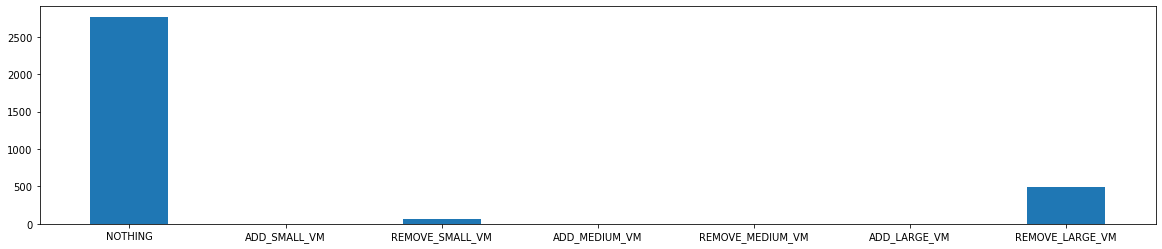

In [5]:
plot_action_histogram(predictions)

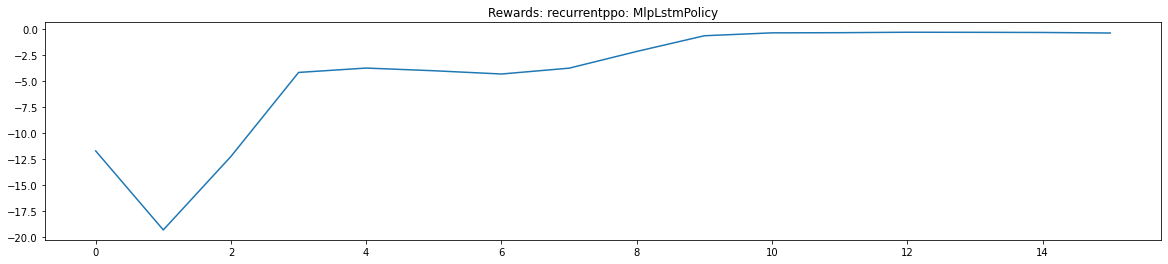

In [6]:
plot_training_data("../best_model/recurrentppo/MlpLstmPolicy/best_model_rewards.csv", data_type='reward', title='recurrentppo: MlpLstmPolicy')

In [7]:
from ppo_policy import RecurrentPPOPolicy
ppo_net = RecurrentPPOPolicy(model.observation_space, model.action_space, model.lr_schedule, model)

In [8]:
ppo_net.lstm_hidden_state_shape

(1, 1, 256)

In [9]:
x = torch.tensor(X[0])
# x = torch.tensor(X)
ppo_net.forward(
    x, 
    lstm_states=RNNStates(
        pi=(torch.zeros(ppo_net.lstm_hidden_state_shape), torch.zeros(ppo_net.lstm_hidden_state_shape)), 
        vf=(torch.zeros(ppo_net.lstm_hidden_state_shape), torch.zeros(ppo_net.lstm_hidden_state_shape))),
    episode_starts=torch.zeros(0))

/Users/amalota/anaconda3/envs/py37_trainloop/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


tensor([[-0.1025]], grad_fn=<AddmmBackward0>)

In [10]:
x = torch.tensor(X[1])
ppo_net.predict(x)[0][0]

/Users/amalota/anaconda3/envs/py37_trainloop/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


0

In [11]:
N = 500
idxs = np.random.choice(np.arange(X.shape[0]), size=N)
X_sample = X[idxs]
X_sample = X[N+40:2*(N+40)]
predictions_sample = predictions[N+40:2*(N+40)]
ig_attributor = IGAttributor(net=ppo_net,
                            policy='mlp',
                            agent='ppo',
                            data=X_sample,
                            predictions=predictions_sample,
                            multiply_by_inputs=True,
                            forward_args=(RNNStates(
                    pi=(torch.zeros(1, 1, 256), torch.zeros(1, 1, 256)), 
                    vf=(torch.zeros(1, 1, 256), torch.zeros(1, 1, 256))),
                    torch.zeros(0)))

Action made: NOTHING


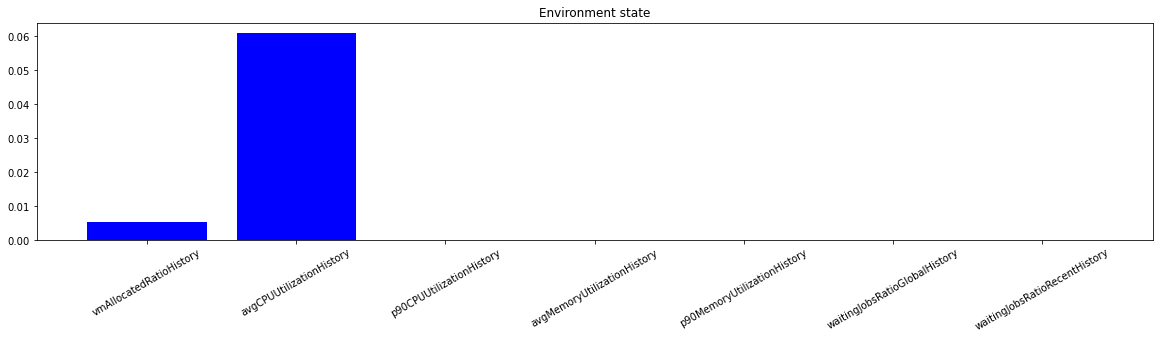

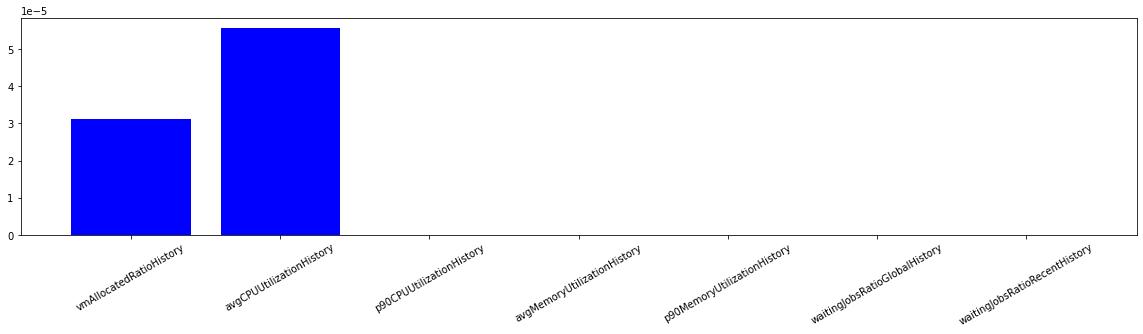

In [12]:
ig_attributor.explain_example(336)

Action made: NOTHING


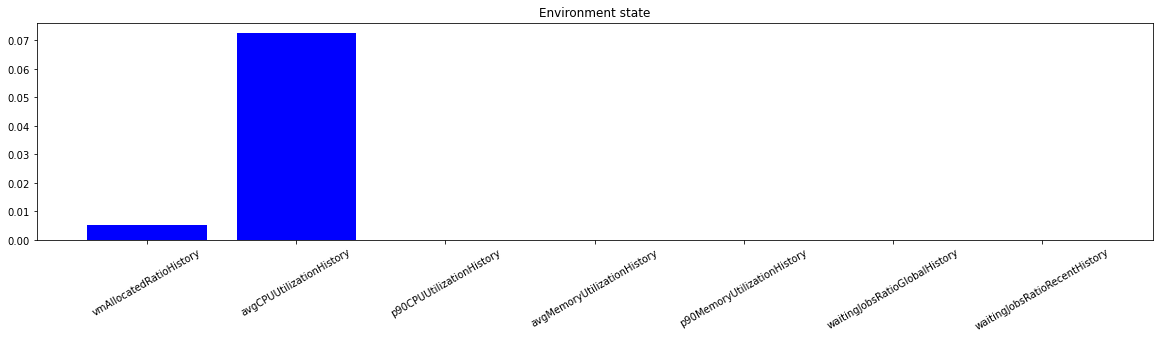

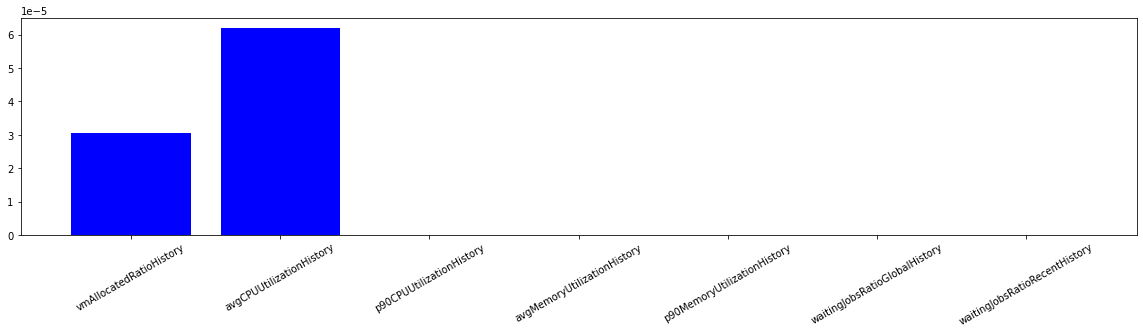

In [13]:
ig_attributor.explain_example(335)

In [14]:
action_observation_map = get_action_observation_map(predictions)

{'ADD_LARGE_VM': 0,
 'ADD_MEDIUM_VM': 0,
 'ADD_SMALL_VM': 4,
 'NOTHING': 2767,
 'REMOVE_LARGE_VM': 495,
 'REMOVE_MEDIUM_VM': 0,
 'REMOVE_SMALL_VM': 70}


In [16]:
idx = action_observation_map['REMOVE_LARGE_VM'].squeeze(1)[:500]

In [17]:
ig_attributor = IGAttributor(net=ppo_net,
                            policy='mlp',
                            agent='ppo',
                            data=X[idx],
                            predictions=predictions[idx],
                            forward_args=(RNNStates(
                    pi=(torch.zeros(1, 1, 256), torch.zeros(1, 1, 256)), 
                    vf=(torch.zeros(1, 1, 256), torch.zeros(1, 1, 256))),
                    torch.zeros(0)))

Action made: REMOVE_LARGE_VM


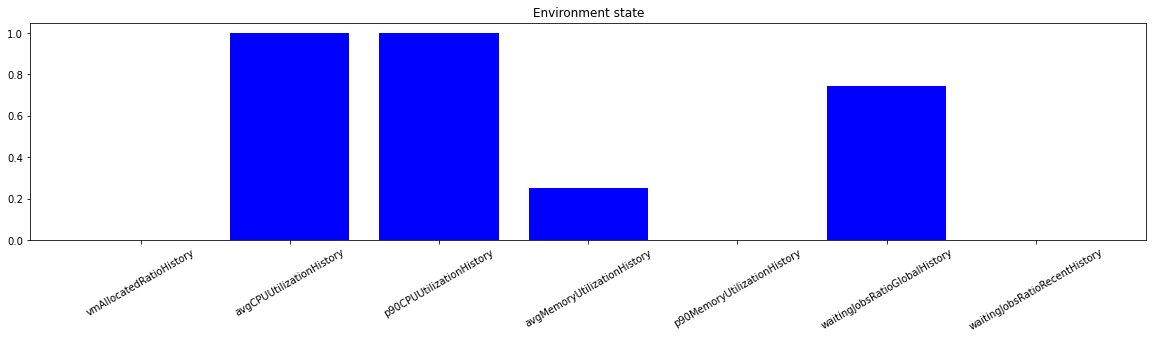

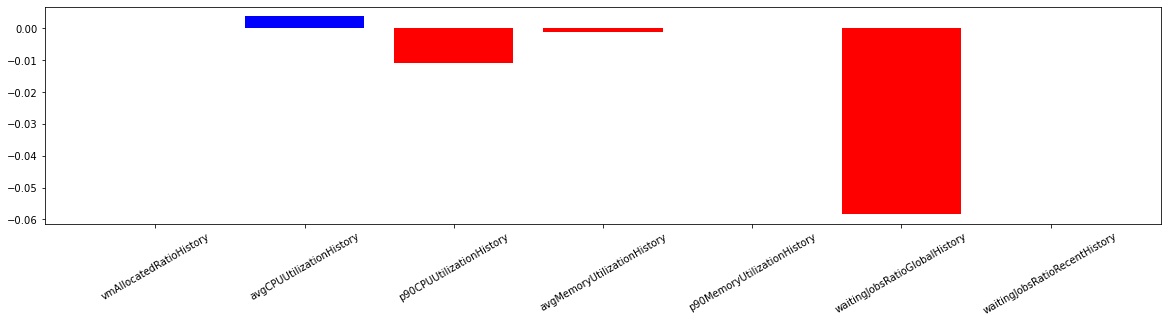

In [18]:
ig_attributor.explain_example(idx=1)

In [19]:
X_manual = torch.Tensor([
    [[0, 1, 1, 1, 1, 1, 1]],
    [[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]],
    [[0, 1, 1, 0, 0, 1, 1]],
    [[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]]
    ])
predictions_manual = []
for _ in X_manual:
    predictions_manual.append(model.predict(X_manual[0])[0][0])
predictions_manual = np.array(predictions_manual)

In [20]:
ig_attributor = IGAttributor(net=ppo_net,
                            policy='mlp',
                            agent='ppo',
                            data=X_manual,
                            predictions=predictions_manual,
                            forward_args=(RNNStates(
                    pi=(torch.zeros(1, 1, 256), torch.zeros(1, 1, 256)), 
                    vf=(torch.zeros(1, 1, 256), torch.zeros(1, 1, 256))),
                    torch.zeros(0)))

Action made: NOTHING


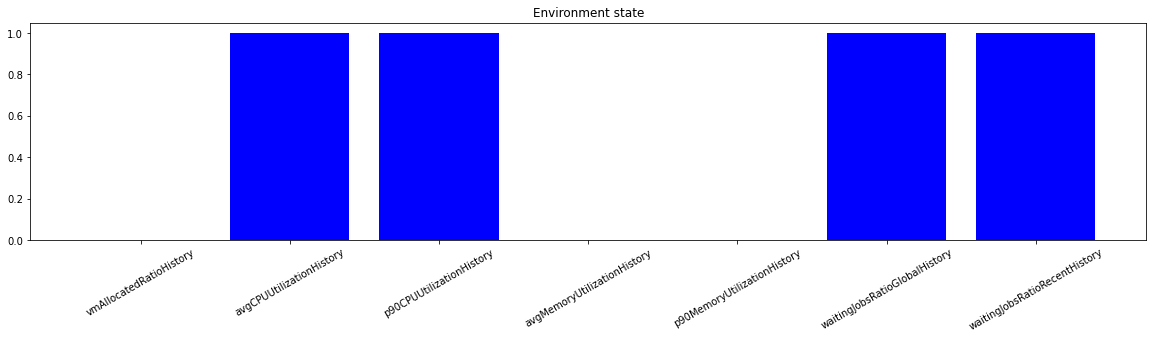

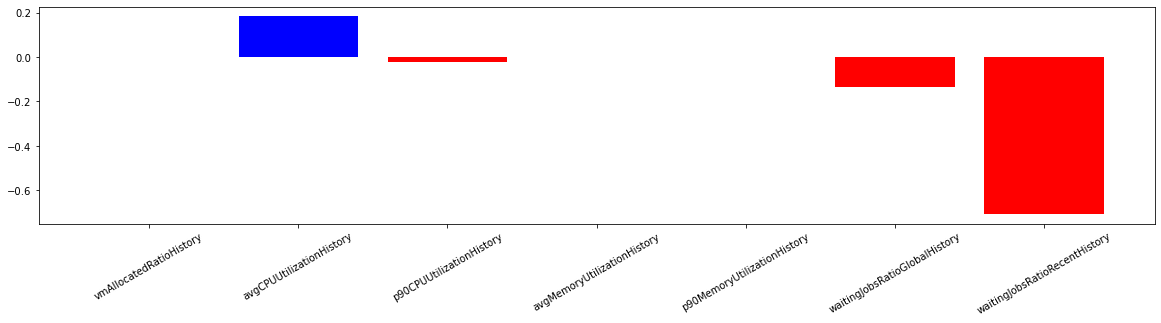

In [21]:
ig_attributor.explain_example(idx=2)

Action made: NOTHING


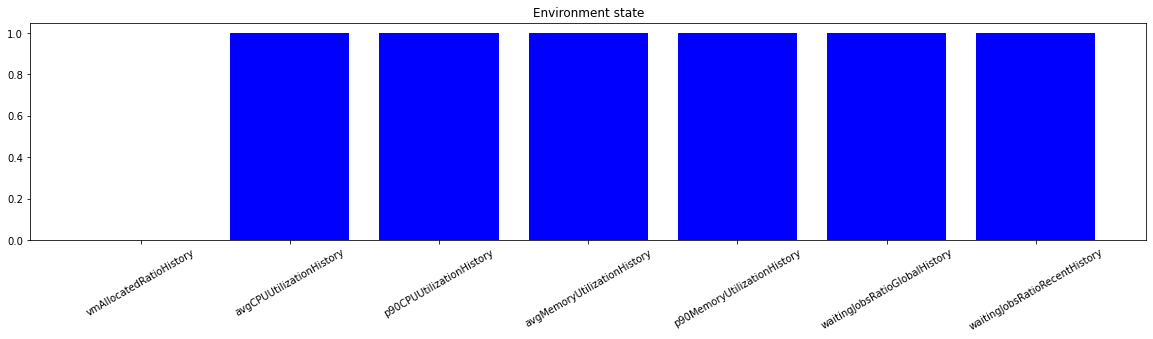

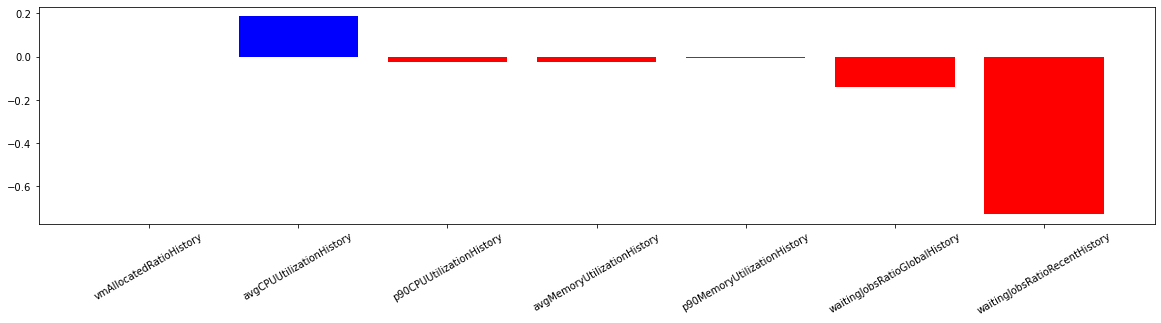

In [22]:
ig_attributor.explain_example(idx=0)